In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames[:5]:
#         print(os.path.join(dirname, filename))

#Clear output = !rm -rf /kaggle/working/*


In [5]:
import os
import torch
from torch import nn

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
#Create train and test folder to split data
mkdir train test

In [9]:
import shutil
import random

# Define paths
parasitized_folder = '/kaggle/input/cell_images/Parasitized/'
uninfected_folder = '/kaggle/input/cell_images/Uninfected/'
train_folder = '/kaggle/working/train'
test_folder = '/kaggle/working/test'

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

train_parasitized = os.path.join(train_folder, 'parasitized')
train_uninfected = os.path.join(train_folder, 'uninfected')
test_parasitized = os.path.join(test_folder, 'parasitized')
test_uninfected = os.path.join(test_folder, 'uninfected')

os.makedirs(train_parasitized , exist_ok=True)
os.makedirs(train_uninfected, exist_ok=True)
os.makedirs(test_parasitized, exist_ok=True)
os.makedirs(test_uninfected, exist_ok=True)

split_ratio = 0.75

# Function to distribute images
def distribute_images(source_folder, train_subfolder, test_subfolder, split_ratio):
    images = os.listdir(source_folder)
    random.shuffle(images)
    split_index = int(len(images) * split_ratio)
    
    for i, image in enumerate(images):
        if i < split_index:
            shutil.copy(os.path.join(source_folder, image), os.path.join(train_subfolder, image))
        else:
            shutil.copy(os.path.join(source_folder, image), os.path.join(test_subfolder, image))

# Distribute images from soft folder
distribute_images(parasitized_folder, train_parasitized, test_parasitized, split_ratio)

# Distribute images from hard folder
distribute_images(uninfected_folder, train_uninfected, test_uninfected, split_ratio)

print("Images have been distributed into train and test folders with subfolders.")

Images have been distributed into train and test folders with subfolders.


Random image path: /kaggle/input/cell_images/Parasitized/C177P138NThinF_IMG_20151201_142942_cell_170.png
Image class: Parasitized
Image height: 106
Image width: 106


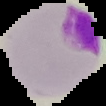

In [10]:
import random
from PIL import Image
from pathlib import Path

random.seed(23) 
image_path = Path('/kaggle/input/cell_images/')

image_path_list = list(image_path.glob("*/*.png"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [11]:
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # Set random seed
    if seed:
        random.seed(seed)

    # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    # Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust image tensor shape for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

# Experiment Tracking

In [12]:
import torch, torchvision
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Reshape all images to 224x224 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) 
])

In [14]:
# Use ImageFolder to create datasets
train_data = datasets.ImageFolder(root=train_folder, 
                                  transform=manual_transforms,
                                  target_transform=None) 

test_data = datasets.ImageFolder(root=test_folder, 
                                 transform=manual_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 20668
    Root location: /kaggle/working/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 6890
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [15]:
len(train_data), len(test_data)

(20668, 6890)

In [16]:
# Get class names as a list
class_names = train_data.classes
class_names

['parasitized', 'uninfected']

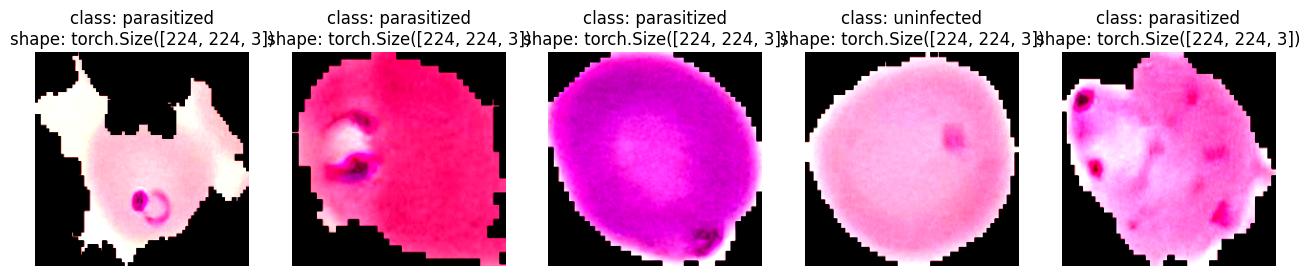

In [17]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

In [18]:
BATCH_SIZE = 1000 #number of samples per batch
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS,
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

In [19]:
img, label = next(iter(train_dataloader))


print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1000, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1000])


In [20]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X).squeeze(dim=1)

        # Calculate and accumulate loss
        # y should be of shape (batch_size, 1) and of type float32
        loss = loss_fn(y_pred, y.float())
        train_loss += loss.item() 

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Apply sigmoid to y_pred to get probabilities
        y_pred_probs = torch.sigmoid(y_pred)
        # Convert probabilities to predicted class (0 or 1) using a threshold of 0.5
        y_pred_class = (y_pred_probs >= 0.5)
        # print(y_pred_class)
        # Calculate accuracy
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [21]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X).squeeze(dim=1)
            
            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y.float())
            test_loss += loss.item()
            
            # Apply sigmoid to logits to get probabilities
            test_pred_probs = torch.sigmoid(test_pred_logits)
            
            # Convert probabilities to predicted class (0 or 1) using a threshold of 0.5
            test_pred_labels = (test_pred_probs >= 0.5)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [22]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 129MB/s] 


In [23]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [24]:
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [25]:
# Freeze all base layers in the model's the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

In [26]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # since it's binary classification
                    bias=True)).to(device)

In [27]:
# Summary after freezing the features and changing the output classifier layer
summary(model, 
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [28]:
# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train model and track results

In [29]:
from typing import Dict, List
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    return results

In [ ]:
# # Set the random seeds
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# # Start the timer
# from timeit import default_timer as timer 
# start_time = timer()

# # Setup training and save the results
# results = train(model=model,
#                 train_dataloader=train_dataloader,
#                 test_dataloader=test_dataloader,
#                 optimizer=optimizer,
#                 loss_fn=loss_fn,
#                 epochs=20,
#                 device=device)

# # End the timer and print out how long it took
# end_time = timer()
# print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [30]:
from torch.utils.tensorboard import SummaryWriter

In [31]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.
    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [ ]:
# # Create an example writer
# example_writer = create_writer(experiment_name="data_10_percent",
#                                model_name="effnetb0",
#                                extra="5_epochs")

In [32]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass

    # Return the filled results at the end of the epochs
    return results

In [33]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    normalize 
])

In [34]:
# Create feature extractor models

# Create an instance of mobilenetv2
mobile_weights = torchvision.models.MobileNet_V2_Weights.DEFAULT 
mobilenet2 = torchvision.models.mobilenet_v2(weights=mobile_weights)

# Get a summary of standard mobilenet2 from torchvision.models (uncomment for full output)
summary(model=mobilenet2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# Get the number of in_features of the MobileNet_V2 classifier layer
print(f"Number of in_features to final layer of MobileNet_V2: {len(mobilenet2.classifier.state_dict()['1.weight'][0])}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s] 


Number of in_features to final layer of MobileNet_V2: 1280


In [35]:
# Set seeds
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [36]:
OUT_FEATURES = 1

# Create an EffNetB0 feature extractor
def create_effnetb0():
    
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the seeds
    set_seeds()

    # Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an mobilenetv2 feature extractor
def create_mobilenetv2():

    weights = torchvision.models.MobileNet_V2_Weights.DEFAULT 
    model = torchvision.models.mobilenet_v2(weights=weights).to(device)

    #Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the seeds
    set_seeds()

    # Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = "mobilenetv2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [37]:
effnetb0 = create_effnetb0() 

# Output summary of the layers in EffNetB0 
summary(model=effnetb0, 
        input_size=(1000, 3, 224, 224), 
        # col_names=["input_size"], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1000, 3, 224, 224]  [1000, 1]            --                   Partial
├─Sequential (features)                                      [1000, 3, 224, 224]  [1000, 1280, 7, 7]   --                   False
│    └─Conv2dNormActivation (0)                              [1000, 3, 224, 224]  [1000, 32, 112, 112] --                   False
│    │    └─Conv2d (0)                                       [1000, 3, 224, 224]  [1000, 32, 112, 112] (864)                False
│    │    └─BatchNorm2d (1)                                  [1000, 32, 112, 112] [1000, 32, 112, 112] (64)                 False
│    │    └─SiLU (2)                                         [1000, 32, 112, 112] [1000, 32, 112, 112] --                   --
│    └─Sequential (1)                                        [1000, 32, 112, 112] [1000

In [38]:
mobilenetv2 = create_mobilenetv2() 

# Output summary of the layers in mobilenetv2 
summary(model=mobilenetv2, 
        input_size=(1000, 3, 224, 224),
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new mobilenetv2 model.


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [1000, 3, 224, 224]  [1000, 1]            --                   Partial
├─Sequential (features)                       [1000, 3, 224, 224]  [1000, 1280, 7, 7]   --                   False
│    └─Conv2dNormActivation (0)               [1000, 3, 224, 224]  [1000, 32, 112, 112] --                   False
│    │    └─Conv2d (0)                        [1000, 3, 224, 224]  [1000, 32, 112, 112] (864)                False
│    │    └─BatchNorm2d (1)                   [1000, 32, 112, 112] [1000, 32, 112, 112] (64)                 False
│    │    └─ReLU6 (2)                         [1000, 32, 112, 112] [1000, 32, 112, 112] --                   --
│    └─InvertedResidual (1)                   [1000, 32, 112, 112] [1000, 16, 112, 112] --                   False
│    │    └─Sequential (conv)                 [1000, 32, 112, 112] [1000, 16,

In [39]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [40]:
# Create epochs list
num_epochs = [15, 20, 25]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "mobilenetv2"]

# Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data": train_dataloader}

In [41]:
%%time
set_seeds(seed=42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs: 
        for model_name in models:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # Select the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_mobilenetv2()
            
            # Create a new loss and optimizer for every model
            loss_fn = nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data
[INFO] Number of epochs: 15
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-02-12/data/effnetb0/15_epochs...


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5368 | train_acc: 0.7872 | test_loss: 0.4213 | test_acc: 0.8980
Epoch: 2 | train_loss: 0.3676 | train_acc: 0.8819 | test_loss: 0.2966 | test_acc: 0.9111
Epoch: 3 | train_loss: 0.3075 | train_acc: 0.8983 | test_loss: 0.2591 | test_acc: 0.9125
Epoch: 4 | train_loss: 0.2775 | train_acc: 0.9055 | test_loss: 0.2381 | test_acc: 0.9181
Epoch: 5 | train_loss: 0.2597 | train_acc: 0.9088 | test_loss: 0.2235 | test_acc: 0.9236
Epoch: 6 | train_loss: 0.2464 | train_acc: 0.9142 | test_loss: 0.2141 | test_acc: 0.9271
Epoch: 7 | train_loss: 0.2395 | train_acc: 0.9143 | test_loss: 0.2068 | test_acc: 0.9289
Epoch: 8 | train_loss: 0.2316 | train_acc: 0.9183 | test_loss: 0.2004 | test_acc: 0.9311
Epoch: 9 | train_loss: 0.2248 | train_acc: 0.9220 | test_loss: 0.1958 | test_acc: 0.9312
Epoch: 10 | train_loss: 0.2209 | train_acc: 0.9203 | test_loss: 0.1923 | test_acc: 0.9317
Epoch: 11 | train_loss: 0.2196 | train_acc: 0.9194 | test_loss: 0.1895 | test_acc: 0.9329
Epoch: 12 | train_l

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5917 | train_acc: 0.7484 | test_loss: 0.5002 | test_acc: 0.8608
Epoch: 2 | train_loss: 0.4583 | train_acc: 0.8389 | test_loss: 0.4042 | test_acc: 0.8726
Epoch: 3 | train_loss: 0.3902 | train_acc: 0.8633 | test_loss: 0.3563 | test_acc: 0.8859
Epoch: 4 | train_loss: 0.3536 | train_acc: 0.8764 | test_loss: 0.3252 | test_acc: 0.8937
Epoch: 5 | train_loss: 0.3280 | train_acc: 0.8864 | test_loss: 0.3035 | test_acc: 0.9021
Epoch: 6 | train_loss: 0.3116 | train_acc: 0.8883 | test_loss: 0.2883 | test_acc: 0.9061
Epoch: 7 | train_loss: 0.2964 | train_acc: 0.8943 | test_loss: 0.2762 | test_acc: 0.9105
Epoch: 8 | train_loss: 0.2864 | train_acc: 0.8970 | test_loss: 0.2659 | test_acc: 0.9107
Epoch: 9 | train_loss: 0.2787 | train_acc: 0.8989 | test_loss: 0.2580 | test_acc: 0.9136
Epoch: 10 | train_loss: 0.2697 | train_acc: 0.9012 | test_loss: 0.2523 | test_acc: 0.9141
Epoch: 11 | train_loss: 0.2654 | train_acc: 0.9034 | test_loss: 0.2463 | test_acc: 0.9163
Epoch: 12 | train_l

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5368 | train_acc: 0.7872 | test_loss: 0.4213 | test_acc: 0.8980
Epoch: 2 | train_loss: 0.3676 | train_acc: 0.8819 | test_loss: 0.2966 | test_acc: 0.9111
Epoch: 3 | train_loss: 0.3075 | train_acc: 0.8983 | test_loss: 0.2591 | test_acc: 0.9125
Epoch: 4 | train_loss: 0.2775 | train_acc: 0.9055 | test_loss: 0.2381 | test_acc: 0.9181
Epoch: 5 | train_loss: 0.2597 | train_acc: 0.9088 | test_loss: 0.2235 | test_acc: 0.9236
Epoch: 6 | train_loss: 0.2464 | train_acc: 0.9142 | test_loss: 0.2141 | test_acc: 0.9271
Epoch: 7 | train_loss: 0.2395 | train_acc: 0.9143 | test_loss: 0.2068 | test_acc: 0.9289
Epoch: 8 | train_loss: 0.2316 | train_acc: 0.9183 | test_loss: 0.2004 | test_acc: 0.9311
Epoch: 9 | train_loss: 0.2248 | train_acc: 0.9220 | test_loss: 0.1958 | test_acc: 0.9312
Epoch: 10 | train_loss: 0.2209 | train_acc: 0.9203 | test_loss: 0.1923 | test_acc: 0.9317
Epoch: 11 | train_loss: 0.2196 | train_acc: 0.9194 | test_loss: 0.1895 | test_acc: 0.9329
Epoch: 12 | train_l

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5917 | train_acc: 0.7484 | test_loss: 0.5002 | test_acc: 0.8608
Epoch: 2 | train_loss: 0.4583 | train_acc: 0.8389 | test_loss: 0.4042 | test_acc: 0.8726
Epoch: 3 | train_loss: 0.3902 | train_acc: 0.8633 | test_loss: 0.3563 | test_acc: 0.8859
Epoch: 4 | train_loss: 0.3536 | train_acc: 0.8764 | test_loss: 0.3252 | test_acc: 0.8937
Epoch: 5 | train_loss: 0.3280 | train_acc: 0.8864 | test_loss: 0.3035 | test_acc: 0.9021
Epoch: 6 | train_loss: 0.3116 | train_acc: 0.8883 | test_loss: 0.2883 | test_acc: 0.9061
Epoch: 7 | train_loss: 0.2964 | train_acc: 0.8943 | test_loss: 0.2762 | test_acc: 0.9105
Epoch: 8 | train_loss: 0.2864 | train_acc: 0.8970 | test_loss: 0.2659 | test_acc: 0.9107
Epoch: 9 | train_loss: 0.2787 | train_acc: 0.8989 | test_loss: 0.2580 | test_acc: 0.9136
Epoch: 10 | train_loss: 0.2697 | train_acc: 0.9012 | test_loss: 0.2523 | test_acc: 0.9141
Epoch: 11 | train_loss: 0.2654 | train_acc: 0.9034 | test_loss: 0.2463 | test_acc: 0.9163
Epoch: 12 | train_l

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5368 | train_acc: 0.7872 | test_loss: 0.4213 | test_acc: 0.8980
Epoch: 2 | train_loss: 0.3676 | train_acc: 0.8819 | test_loss: 0.2966 | test_acc: 0.9111
Epoch: 3 | train_loss: 0.3075 | train_acc: 0.8983 | test_loss: 0.2591 | test_acc: 0.9125
Epoch: 4 | train_loss: 0.2775 | train_acc: 0.9055 | test_loss: 0.2381 | test_acc: 0.9181
Epoch: 5 | train_loss: 0.2597 | train_acc: 0.9088 | test_loss: 0.2235 | test_acc: 0.9236
Epoch: 6 | train_loss: 0.2464 | train_acc: 0.9142 | test_loss: 0.2141 | test_acc: 0.9271
Epoch: 7 | train_loss: 0.2395 | train_acc: 0.9143 | test_loss: 0.2068 | test_acc: 0.9289
Epoch: 8 | train_loss: 0.2316 | train_acc: 0.9183 | test_loss: 0.2004 | test_acc: 0.9311
Epoch: 9 | train_loss: 0.2248 | train_acc: 0.9220 | test_loss: 0.1958 | test_acc: 0.9312
Epoch: 10 | train_loss: 0.2209 | train_acc: 0.9203 | test_loss: 0.1923 | test_acc: 0.9317
Epoch: 11 | train_loss: 0.2196 | train_acc: 0.9194 | test_loss: 0.1895 | test_acc: 0.9329
Epoch: 12 | train_l

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5917 | train_acc: 0.7484 | test_loss: 0.5002 | test_acc: 0.8608
Epoch: 2 | train_loss: 0.4583 | train_acc: 0.8389 | test_loss: 0.4042 | test_acc: 0.8726
Epoch: 3 | train_loss: 0.3902 | train_acc: 0.8633 | test_loss: 0.3563 | test_acc: 0.8859
Epoch: 4 | train_loss: 0.3536 | train_acc: 0.8764 | test_loss: 0.3252 | test_acc: 0.8937
Epoch: 5 | train_loss: 0.3280 | train_acc: 0.8864 | test_loss: 0.3035 | test_acc: 0.9021
Epoch: 6 | train_loss: 0.3116 | train_acc: 0.8883 | test_loss: 0.2883 | test_acc: 0.9061
Epoch: 7 | train_loss: 0.2964 | train_acc: 0.8943 | test_loss: 0.2762 | test_acc: 0.9105
Epoch: 8 | train_loss: 0.2864 | train_acc: 0.8970 | test_loss: 0.2659 | test_acc: 0.9107
Epoch: 9 | train_loss: 0.2787 | train_acc: 0.8989 | test_loss: 0.2580 | test_acc: 0.9136
Epoch: 10 | train_loss: 0.2697 | train_acc: 0.9012 | test_loss: 0.2523 | test_acc: 0.9141
Epoch: 11 | train_loss: 0.2654 | train_acc: 0.9034 | test_loss: 0.2463 | test_acc: 0.9163
Epoch: 12 | train_l

In [46]:
%load_ext tensorboard
%tensorboard --logdir=/kaggle/working/runs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 7540), started 0:00:32 ago. (Use '!kill 7540' to kill it.)

<IPython.core.display.Javascript object>

In [47]:
best_model_path = "models/07_effnetb0_data_25_epochs.pth"

best_model = create_effnetb0()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model.


<ipython-input-47-7583ebb37cf6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [48]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB0 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB0 feature extractor model size: 15 MB


In [49]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    img = Image.open(image_path)
    
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))
      target_image_pred_probs = torch.sigmoid(target_image_pred)
      
      # Convert probabilities to predicted class (0 or 1) using a threshold of 0.5
      target_image_pred_label = (target_image_pred_probs >= 0.5)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

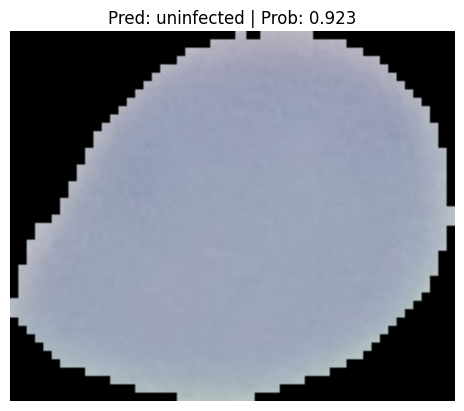

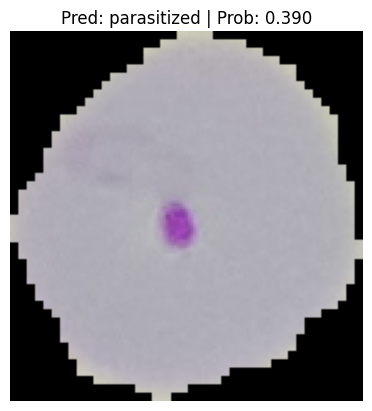

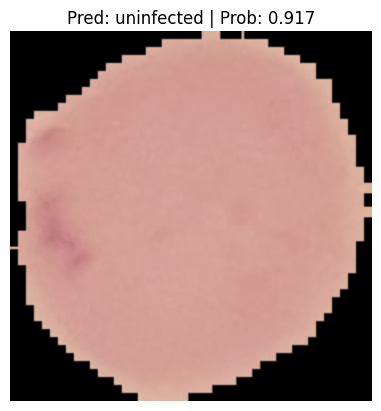

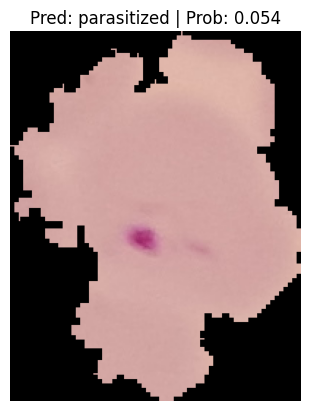

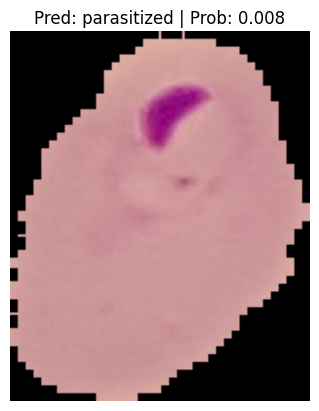

In [50]:
# Testing the model on random images in test dataset
import random
num_images_to_plot = 5
test_image_path_list = list(Path(test_folder).glob("*/*.png")) 
test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_images_to_plot) 

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))